In [2]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import asyncio
import concurrent.futures
import time
from networkx.algorithms.community import asyn_fluidc

In [3]:
asteroid_color = pd.read_csv("data/Asteroid_color_df.csv")

In [3]:
asteroid_color

,spkid,pha,albedo,diameter,BV,UB,spec_B,spec_T,class
0,20000001,N,0.0900,939.400,0.713,0.426,C,G,MBA
1,20000002,N,0.1550,513.000,0.635,0.284,B,B,MBA
2,20000003,N,0.2140,246.596,0.824,0.433,Sk,S,MBA
3,20000004,N,0.4228,525.400,0.782,0.492,V,V,MBA
4,20000005,N,0.2740,106.699,0.826,0.411,S,S,MBA
...,...,...,...,...,...,...,...,...,...
2242,20003248,N,0.0500,36.553,NaN,NaN,D,NaN,OMB
2243,20003254,N,0.0730,31.104,NaN,NaN,T,NaN,OMB
2244,20096177,N,NaN,3.400,NaN,NaN,NaN,D,OMB
2245,20405058,N,0.1810,5.600,NaN,NaN,X,NaN,OMB


In [4]:
(asteroid_color['pha'] == 'Y').sum()

93

In [5]:
asteroid_color['class'].unique()

array(['MBA', 'AMO', 'APO', 'ATE', 'CEN', 'IMB', 'TJN', 'MCA', 'OMB',
       'TNO'], dtype=object)

In [6]:
asteroid_color['class'] = asteroid_color['class'].astype('category')

In [7]:
asteroid_color['BV'].dropna().shape

(1021,)

In [8]:
asteroid_color['UB'].dropna().shape

(979,)

In [9]:
asteroid_color['spec_B'].dropna().shape

(1666,)

In [10]:
asteroid_color['spec_B'].value_counts()

spec_B
S        446
C        152
Ch       139
X        138
Sq       114
Xc        67
B         66
Sl        56
V         48
Xk        47
L         41
Sa        38
Cb        37
K         37
Xe        30
Sk        29
Sr        27
Q         20
T         19
A         17
S:        16
Ld        15
Cgh       15
D         13
Cg         9
O          7
X:         6
R          5
U          4
C:         3
Sq:        2
K:         1
S(IV)      1
V:         1
Name: count, dtype: int64

In [11]:
asteroid_color['spec_T'].dropna().shape

(980,)

In [12]:
asteroid_color['spec_T'].value_counts()

spec_T
S       338
C       140
X        52
M        38
D        35
       ... 
STGD      1
DX:       1
CP:       1
SD        1
CFXU      1
Name: count, Length: 131, dtype: int64

In [13]:
asteroid_color['pha'] = asteroid_color['pha'].astype('category')

In [14]:
asteroid_color.dtypes

spkid          int64
pha         category
albedo       float64
diameter     float64
BV           float64
UB           float64
spec_B        object
spec_T        object
class       category
dtype: object

## Iter

In [15]:
start_time = time.time() 

G = nx.Graph()

# Step 2: Add nodes (each asteroid is a node, identified by its 'spkid')
for index, row in asteroid_color.iterrows():
    G.add_node(row['spkid'], BV=row['BV'], UB=row['UB'], spec_B=row['spec_B'], spec_T=row['spec_T'])

# Step 3: Define edges based on similarity in spectra
# Example: Connect nodes if they have the same spectral type or similar color indices

def are_similar(row1, row2, bv_threshold=0.05, ub_threshold=0.05):
    # Check if spectral types are the same
    spec_similar = (row1['spec_B'] == row2['spec_B']) or (row1['spec_T'] == row2['spec_T'])
    
    # Check if BV and UB color indices are close (within given thresholds)
    bv_similar = abs(row1['BV'] - row2['BV']) < bv_threshold if pd.notna(row1['BV']) and pd.notna(row2['BV']) else False
    ub_similar = abs(row1['UB'] - row2['UB']) < ub_threshold if pd.notna(row1['UB']) and pd.notna(row2['UB']) else False

    # Nodes are connected if their spectra are similar or color indices are close
    return spec_similar or bv_similar or ub_similar

# Step 4: Add edges
for i, row1 in asteroid_color.iterrows():
    for j, row2 in asteroid_color.iterrows():
        if i != j and are_similar(row1, row2):
            G.add_edge(row1['spkid'], row2['spkid'])

end_time = time.time()
execution_time = end_time - start_time

print(f"Execution time: {execution_time:.2f} seconds")

Execution time: 141.93 seconds


### With Concurrent

In [16]:
start_time = time.time() 

# Step 2: Add nodes (each asteroid is a node, identified by its 'spkid')
for index, row in asteroid_color.iterrows():
    G.add_node(row['spkid'], BV=row['BV'], UB=row['UB'], spec_B=row['spec_B'], spec_T=row['spec_T'])

# Step 3: Define edges based on similarity in spectra
# Example: Connect nodes if they have the same spectral type or similar color indices

def are_similar(row1, row2, bv_threshold=0.05, ub_threshold=0.05):
    # Check if spectral types are the same
    spec_similar = (row1['spec_B'] == row2['spec_B']) or (row1['spec_T'] == row2['spec_T'])
    
    # Check if BV and UB color indices are close (within given thresholds)
    bv_similar = abs(row1['BV'] - row2['BV']) < bv_threshold if pd.notna(row1['BV']) and pd.notna(row2['BV']) else False
    ub_similar = abs(row1['UB'] - row2['UB']) < ub_threshold if pd.notna(row1['UB']) and pd.notna(row2['UB']) else False

    # Nodes are connected if their spectra are similar or color indices are close
    return spec_similar or bv_similar or ub_similar

# Step 4: Parallel edge creation using ThreadPoolExecutor
def add_edges_for_node(node_idx):
    row1 = asteroid_color.iloc[node_idx]
    edges = []
    for j, row2 in asteroid_color.iterrows():
        if node_idx != j and are_similar(row1, row2):
            edges.append((row1['spkid'], row2['spkid']))  # Collect edge
    return edges

# Step 5: Use ThreadPoolExecutor to parallelize edge creation
with concurrent.futures.ThreadPoolExecutor() as executor:
    # Submit tasks for each node
    futures = [executor.submit(add_edges_for_node, i) for i in range(len(asteroid_color))]

    # Collect and add edges to the graph
    for future in concurrent.futures.as_completed(futures):
        for edge in future.result():
            G.add_edge(*edge)

end_time = time.time()
execution_time = end_time - start_time

print(f"Execution time: {execution_time:.2f} seconds")

Execution time: 148.29 seconds


### With asyncio

In [18]:
start_time = time.time() 

# Step 2: Add nodes (each asteroid is a node, identified by its 'spkid')
for index, row in asteroid_color.iterrows():
    G.add_node(row['spkid'], BV=row['BV'], UB=row['UB'], spec_B=row['spec_B'], spec_T=row['spec_T'])

# Step 3: Define edges based on similarity in spectra
def are_similar(row1, row2, bv_threshold=0.05, ub_threshold=0.05):
    # Check if spectral types are the same
    spec_similar = (row1['spec_B'] == row2['spec_B']) or (row1['spec_T'] == row2['spec_T'])

    # Check if BV and UB color indices are close (within given thresholds)
    bv_similar = abs(row1['BV'] - row2['BV']) < bv_threshold if pd.notna(row1['BV']) and pd.notna(row2['BV']) else False
    ub_similar = abs(row1['UB'] - row2['UB']) < ub_threshold if pd.notna(row1['UB']) and pd.notna(row2['UB']) else False

    # Nodes are connected if their spectra are similar or color indices are close
    return spec_similar or bv_similar or ub_similar

# Step 4: Define an async function to calculate edges for a node
async def add_edges_for_node(node_idx, executor):
    row1 = asteroid_color.iloc[node_idx]
    edges = []

    # Offload the comparison to the thread pool
    loop = asyncio.get_running_loop()

    # Asynchronously run the pairwise comparisons in a thread pool
    for j, row2 in asteroid_color.iterrows():
        if node_idx != j:
            result = await loop.run_in_executor(
                executor, are_similar, row1, row2
            )
            if result:
                edges.append((row1['spkid'], row2['spkid']))
    
    return edges

# Step 5: Main async function to coordinate the tasks
async def build_graph():
    # Use ThreadPoolExecutor to offload CPU-bound tasks
    with concurrent.futures.ThreadPoolExecutor() as executor:
        tasks = []
        
        # Submit async tasks for each node
        for i in range(len(asteroid_color)):
            tasks.append(add_edges_for_node(i, executor))
        
        # Gather the results (edges) asynchronously
        results = await asyncio.gather(*tasks)

        # Add edges to the graph after computation
        for edges in results:
            for edge in edges:
                G.add_edge(*edge)

# Step 6: Instead of asyncio.run(), directly await in Jupyter
await build_graph()

end_time = time.time()
execution_time = end_time - start_time

print(f"Execution time: {execution_time:.2f} seconds")

Execution time: 436.98 seconds


In [19]:
# Step 5: Define node colors based on 'pha' column
node_colors = []
node_labels = {}
for node in G.nodes():
    # Find the corresponding row for the node in the asteroid_color dataframe
    pha_value = asteroid_color.loc[asteroid_color['spkid'] == node, 'pha'].values[0]
    
    if pha_value == 'Y':  # Check if pha is 1
        node_size = 20
        node_colors.append('red')  # Color for PHA = 1
        #node_labels[node] = node
        
    else:
        node_size = 10
        node_colors.append('yellow')  # Default color for others

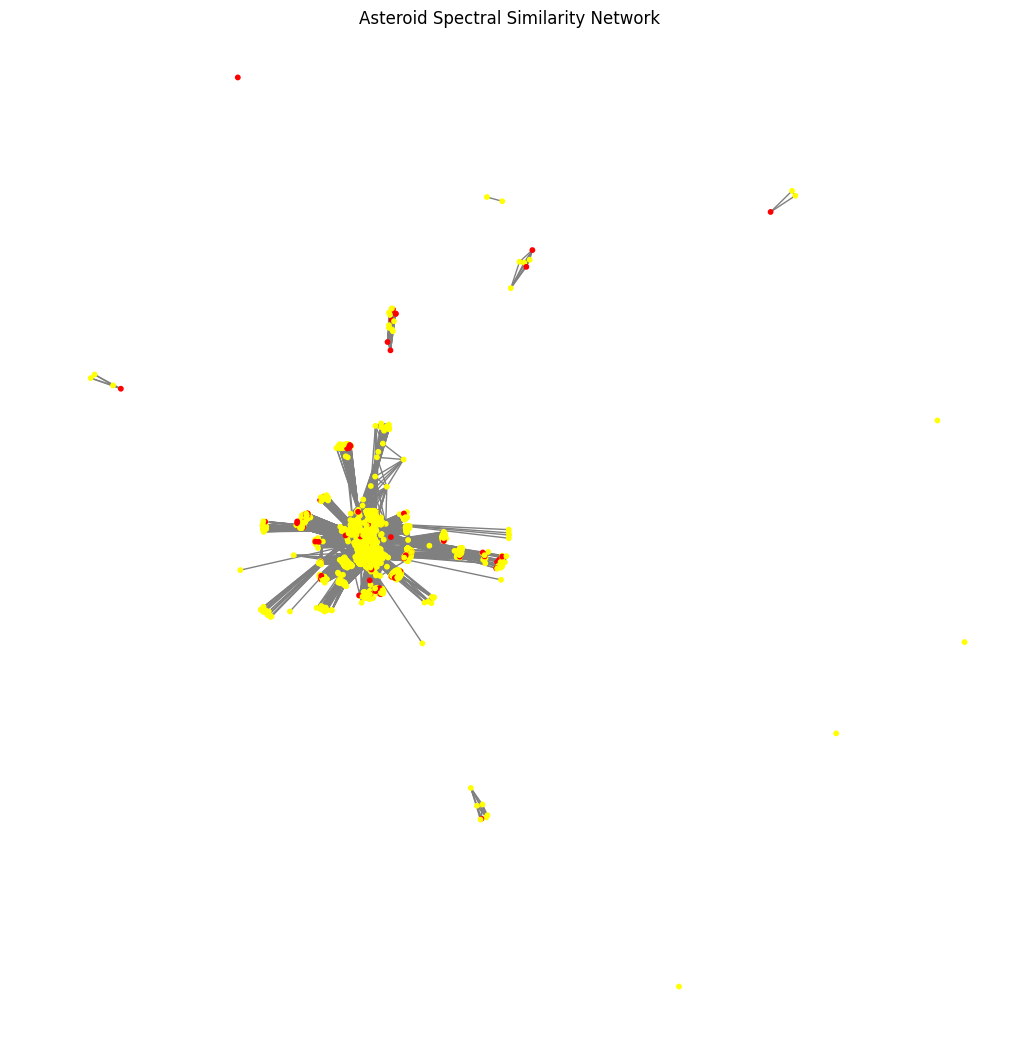

Execution time: 8.81 seconds


In [20]:
start_time = time.time() 

pos = nx.spring_layout(G, iterations=15, seed=42)
plt.figure(figsize=(10, 10))
nx.draw(G, with_labels=False, pos = pos, node_size=node_size, node_color=node_colors, font_size=8, edge_color="gray")

# Draw only labels for nodes where pha == 'Y'
#nx.draw_networkx_labels(G, pos, font_color='black', font_size=10)  #labels=node_labels

plt.title("Asteroid Spectral Similarity Network")
plt.show()

# Optional: Save the graph
nx.write_gml(G, "asteroid_spectral_network.gml")

end_time = time.time()
execution_time = end_time - start_time

print(f"Execution time: {execution_time:.2f} seconds")

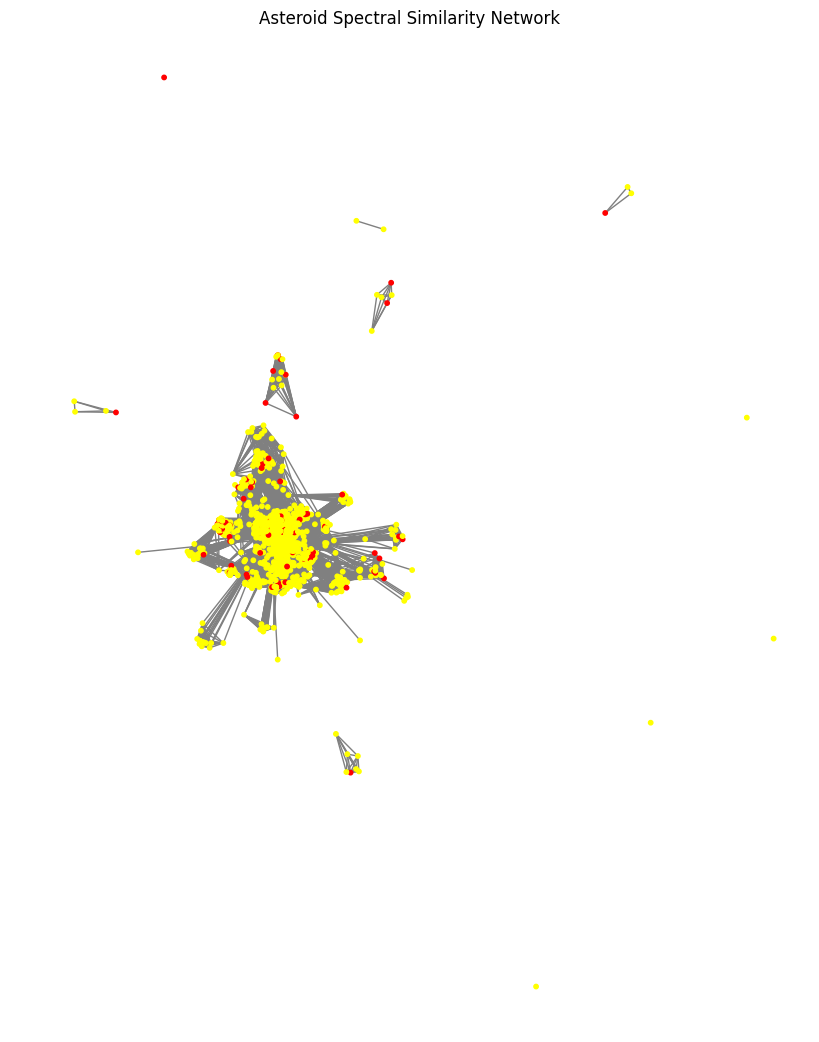

Execution time: 6.86 seconds


In [21]:
start_time = time.time() 

pos = nx.spring_layout(G, iterations=10, seed=42)
plt.figure(figsize=(8, 10))
nx.draw(G, with_labels=False, pos = pos, node_size=node_size, node_color=node_colors, font_size=8, edge_color="gray")

# Draw only labels for nodes where pha == 'Y'
#nx.draw_networkx_labels(G, pos, font_color='black', font_size=10)  #labels=node_labels

plt.title("Asteroid Spectral Similarity Network")
plt.show()

# Optional: Save the graph
nx.write_gml(G, "asteroid_spectral_network.gml")

end_time = time.time()
execution_time = end_time - start_time

print(f"Execution time: {execution_time:.2f} seconds")

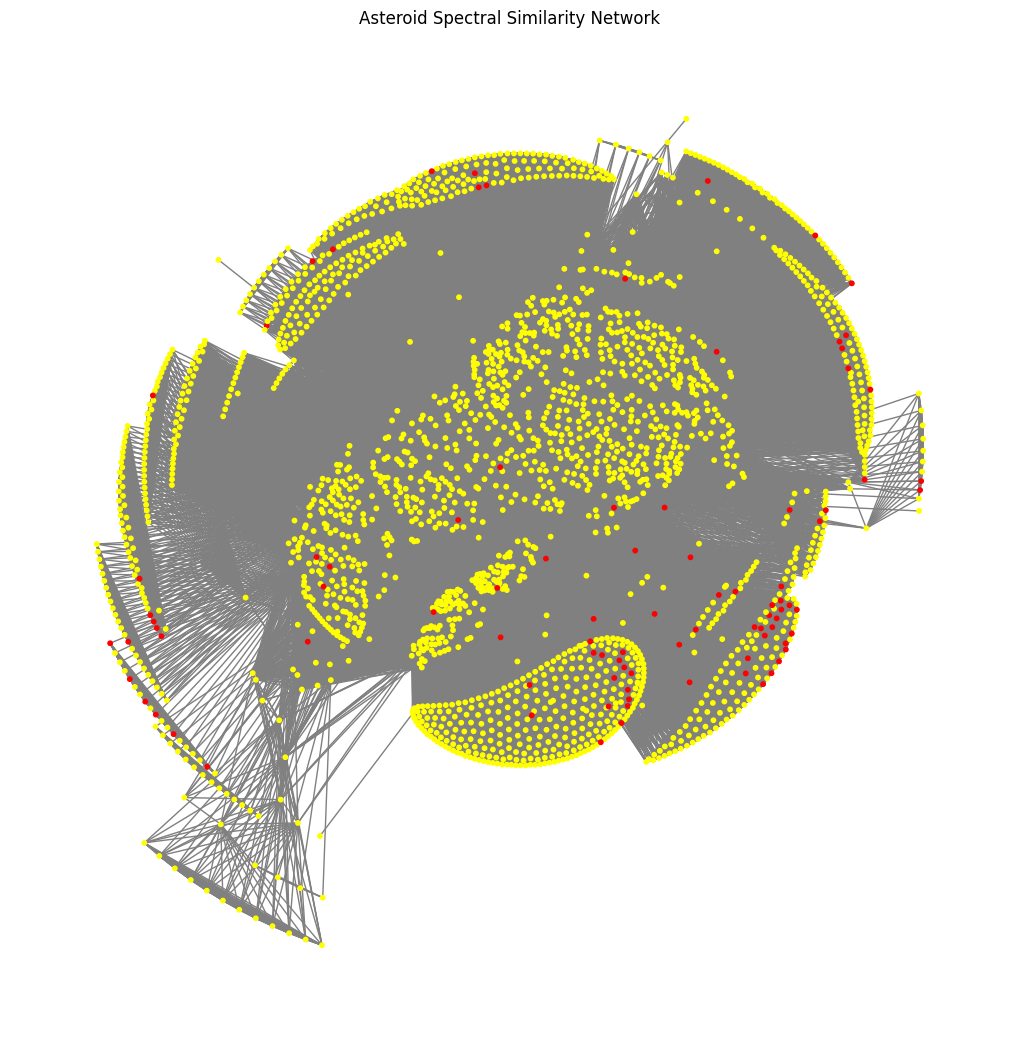

Execution time: 471.13 seconds


In [22]:
start_time = time.time() 

pos = nx.kamada_kawai_layout(G)
plt.figure(figsize=(10, 10))
nx.draw(G, with_labels=False, pos = pos, node_size=node_size, node_color=node_colors, font_size=8, edge_color="gray")

# Draw only labels for nodes where pha == 'Y'
#nx.draw_networkx_labels(G, pos, font_color='black', font_size=10)  #labels=node_labels

plt.title("Asteroid Spectral Similarity Network")
plt.show()

# Optional: Save the graph
nx.write_gml(G, "asteroid_spectral_network.gml")

end_time = time.time()
execution_time = end_time - start_time

print(f"Execution time: {execution_time:.2f} seconds")

## Numerical Similarity

In [23]:
# Step 1: Create an empty graph
H = nx.Graph()

# Step 2: Add nodes (each asteroid is a node, identified by its 'spkid')
for index, row in asteroid_color.iterrows():
    H.add_node(row['spkid'], BV=row['BV'], UB=row['UB'], spec_B=row['spec_B'], spec_T=row['spec_T'])

# Step 3: Define a function to calculate similarity score
def similarity_score(row1, row2, bv_threshold=0.05, ub_threshold=0.05):
    score = 0
    
    # Check if spectral types are the same
    if row1['spec_B'] == row2['spec_B'] or row1['spec_T'] == row2['spec_T']:
        score += 1  # Add 1 point if spectral types are the same
    
    # Check if BV and UB color indices are close (within thresholds)
    if pd.notna(row1['BV']) and pd.notna(row2['BV']):
        bv_diff = abs(row1['BV'] - row2['BV'])
        if bv_diff < bv_threshold:
            score += 1 - (bv_diff / bv_threshold)  # Add partial score based on similarity
    
    if pd.notna(row1['UB']) and pd.notna(row2['UB']):
        ub_diff = abs(row1['UB'] - row2['UB'])
        if ub_diff < ub_threshold:
            score += 1 - (ub_diff / ub_threshold)  # Add partial score based on similarity

    return score

# Step 4: Add edges and print similarity
similarity_data = []
similarity_scores = {}  # To store average similarity for each node

# Step 2: Calculate similarity scores and add edges
for i, row1 in asteroid_color.iterrows():
    total_similarity = 0
    count = 0
    for j, row2 in asteroid_color.iterrows():
        if i < j:  # Avoid self-comparisons and duplicates
            score = similarity_score(row1, row2)
            if score > 0:  # Only consider non-zero similarity scores
                # Add to similarity data
                similarity_data.append({
                    'spkid_1': row1['spkid'],
                    'spkid_2': row2['spkid'],
                    'similarity_score': score
                })
                
                # Add edge to the graph
                H.add_edge(row1['spkid'], row2['spkid'], weight=score)

                # Accumulate scores for average calculation
                total_similarity += score
                count += 1
    
    # Calculate average similarity for each node
    similarity_scores[row1['spkid']] = total_similarity / count if count > 0 else 0

# Step 5: Convert similarity data into a DataFrame
similarity_df = pd.DataFrame(similarity_data)
similarity_df.head()

,spkid_1,spkid_2,similarity_score
0,20000001,20000003,0.86
1,20000001,20000005,0.70
2,20000001,20000006,0.46
3,20000001,20000010,1.66
4,20000001,20000011,0.82


In [24]:
print(asteroid_color[asteroid_color['spkid'] == 20000001])
print(asteroid_color[asteroid_color['spkid'] == 20000003])
print(asteroid_color[asteroid_color['spkid'] == 20000006])

      spkid pha  albedo  diameter     BV     UB spec_B spec_T class
0  20000001   N    0.09     939.4  0.713  0.426      C      G   MBA
      spkid pha  albedo  diameter     BV     UB spec_B spec_T class
2  20000003   N   0.214   246.596  0.824  0.433     Sk      S   MBA
      spkid pha  albedo  diameter     BV     UB spec_B spec_T class
5  20000006   N  0.2679    185.18  0.822  0.399      S      S   MBA


In [25]:
# Step 5: Define node colors based on 'pha' column, Normalize similarity scores for colormap
min_similarity = min(similarity_scores.values())
max_similarity = max(similarity_scores.values())
norm = plt.Normalize(vmin=min_similarity, vmax=max_similarity)

# Step 4: Assign colors and sizes to nodes based on similarity
node_colors = []
node_sizes = []

# Define colormap for non-PHA nodes
cmap = plt.cm.Blues  # Blue-Green colormap

for node in H.nodes():
    pha_value = asteroid_color.loc[asteroid_color['spkid'] == node, 'pha'].values[0]
    
    if pha_value == 'Y':
        node_colors.append('red')  # Color for PHA == 'Y'
        node_sizes.append(20)  # Larger size for pha == 'Y'
    else:
        # Get the normalized similarity score and map it to the color
        avg_similarity = similarity_scores[node]
        color_value = cmap(norm(avg_similarity))  # Map similarity to colormap
        node_colors.append(color_value)  # Append the color
        node_sizes.append(10)  # Smaller size for non-PHA nodes

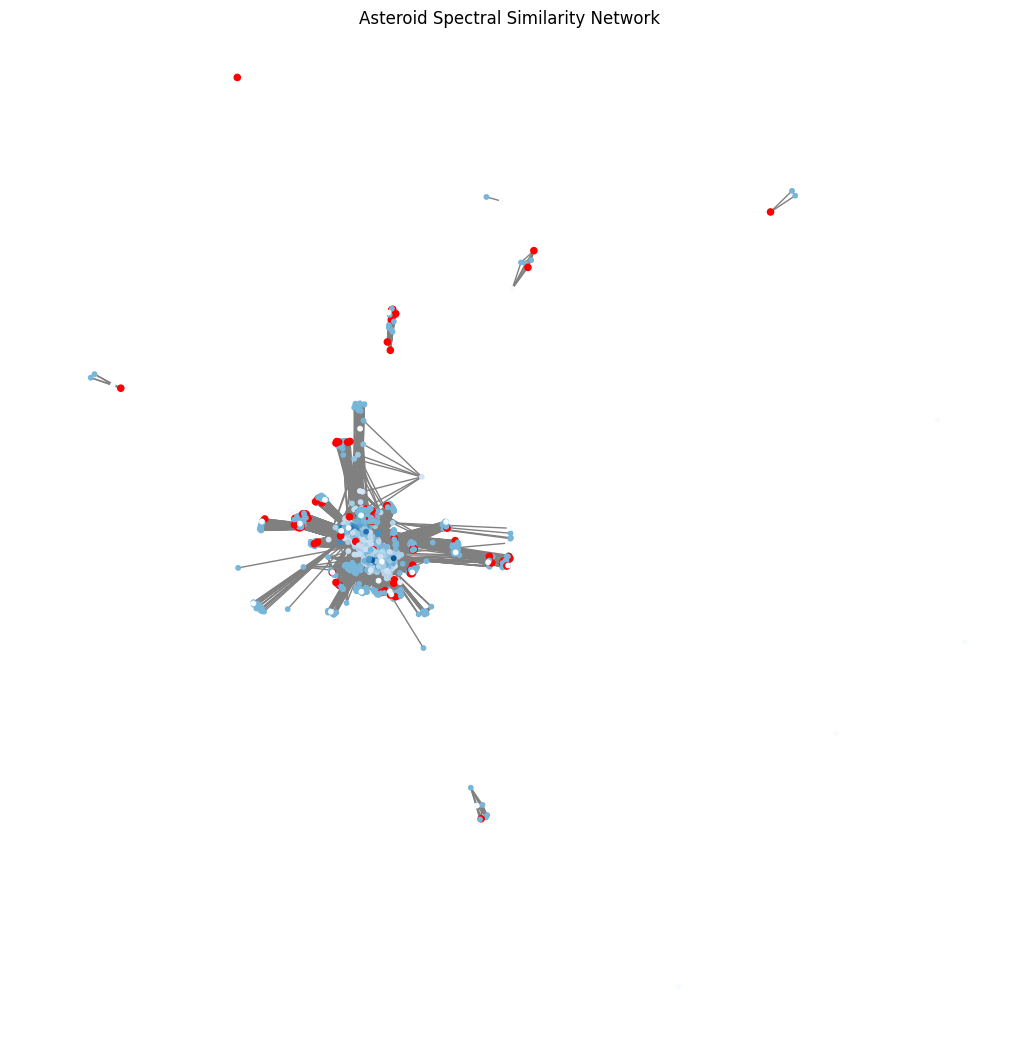

Execution time: 15.01 seconds


In [26]:
start_time = time.time() 

pos = nx.spring_layout(H, iterations=15, seed=42)
plt.figure(figsize=(10, 10))
nx.draw(H, with_labels=False, pos = pos, node_size=node_sizes, node_color=node_colors, font_size=8, edge_color="gray")

# Draw only labels for nodes where pha == 'Y'
#nx.draw_networkx_labels(G, pos, font_color='black', font_size=10)  #labels=node_labels

plt.title("Asteroid Spectral Similarity Network")
plt.show()

# Optional: Save the graph
nx.write_gml(H, "asteroid_spectral_network.gml")

end_time = time.time()
execution_time = end_time - start_time

print(f"Execution time: {execution_time:.2f} seconds")

C:\Users\stack\AppData\Roaming\Python\Python312\site-packages\networkx\drawing\layout.py:745: RuntimeWarning: divide by zero encountered in divide
  direction = np.einsum("ijk,ij->ijk", delta, 1 / (nodesep + np.eye(nNodes) * 1e-3))


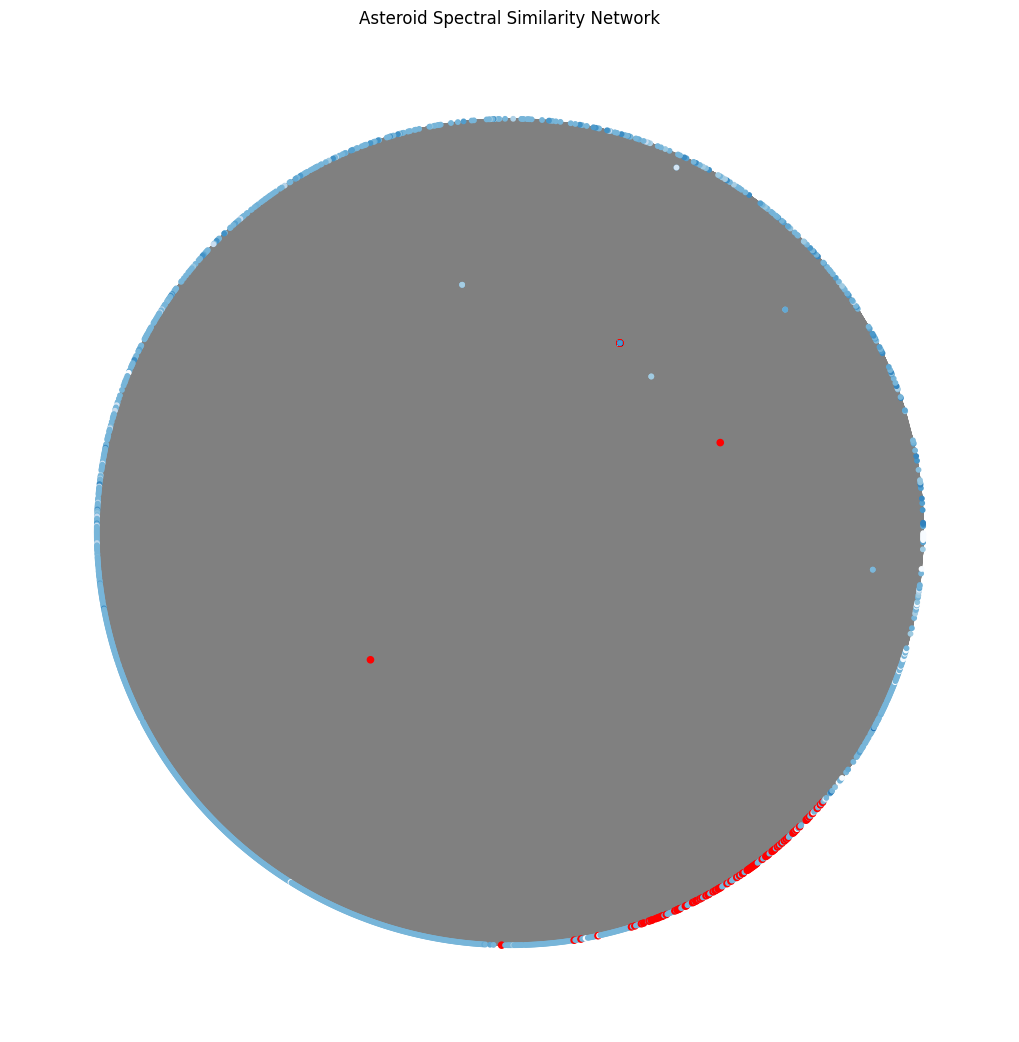

Execution time: 763.05 seconds


In [27]:
start_time = time.time() 

pos = nx.kamada_kawai_layout(H)
plt.figure(figsize=(10, 10))
nx.draw(H, with_labels=False, pos = pos, node_size=node_sizes, node_color=node_colors, font_size=8, edge_color="gray")

# Draw only labels for nodes where pha == 'Y'
#nx.draw_networkx_labels(G, pos, font_color='black', font_size=10)  #labels=node_labels

plt.title("Asteroid Spectral Similarity Network")
plt.show()

# Optional: Save the graph
nx.write_gml(H, "asteroid_spectral_network.gml")

end_time = time.time()
execution_time = end_time - start_time

print(f"Execution time: {execution_time:.2f} seconds")

## With Communities based on class

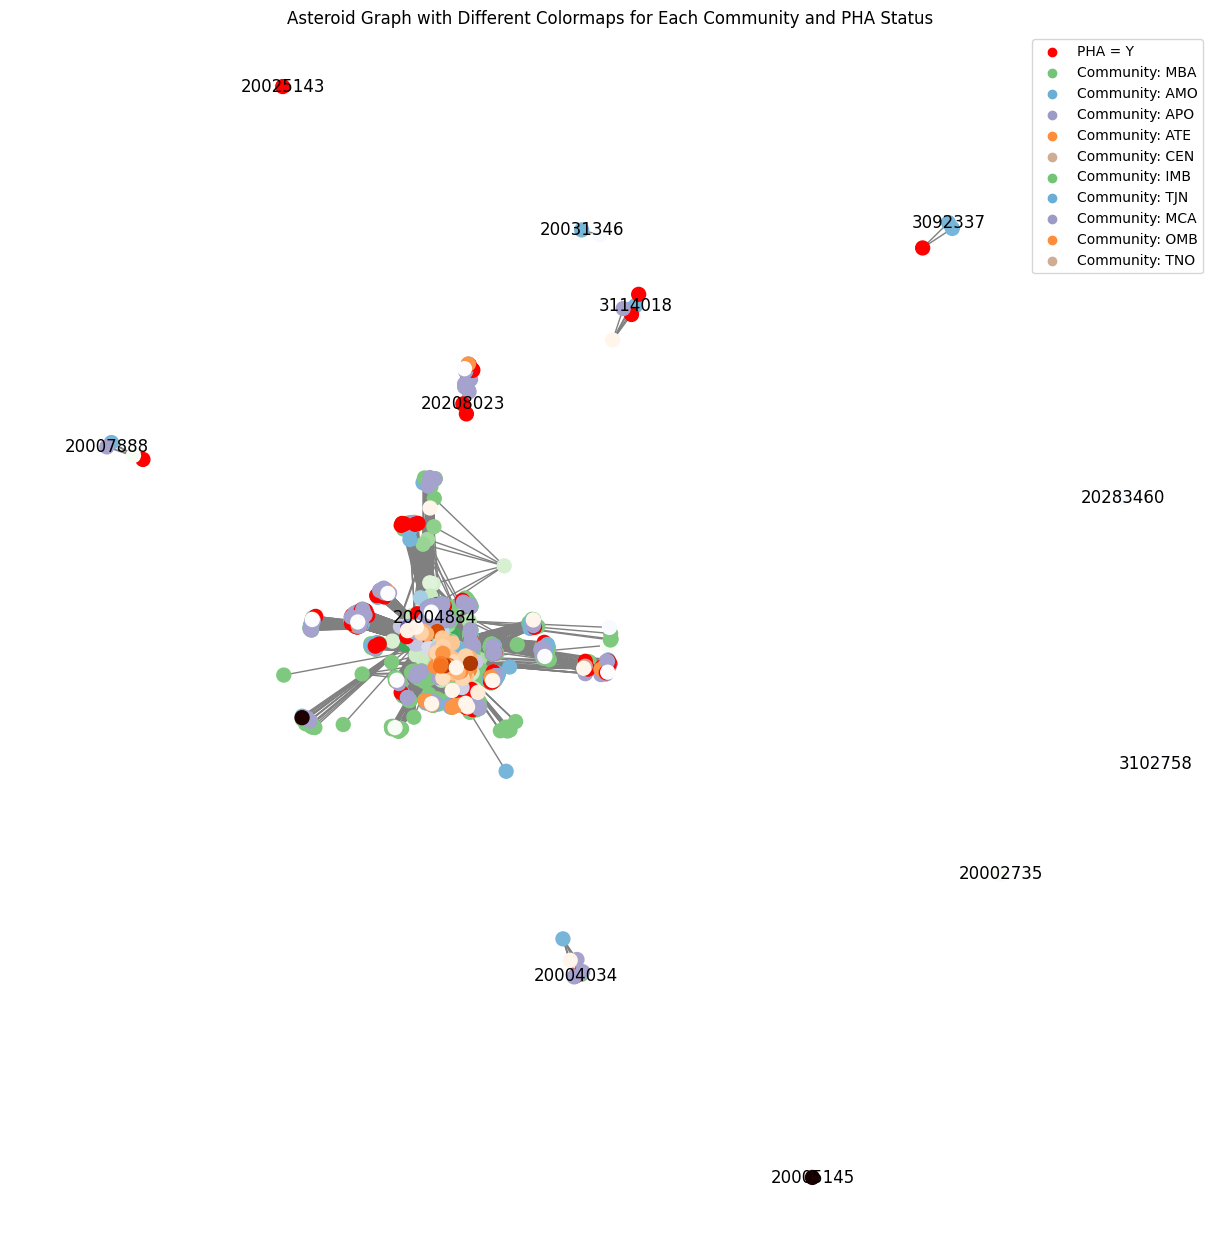

Execution time: 118.44 seconds


In [34]:
start_time = time.time() 

I = nx.Graph()

# Step 1: Add nodes (each asteroid is a node, identified by its 'spkid')
for index, row in asteroid_color.iterrows():
    I.add_node(row['spkid'], 
               BV=row['BV'], 
               UB=row['UB'], 
               spec_B=row['spec_B'], 
               spec_T=row['spec_T'], 
               community=row['class'])  # Store community (class)

# Prepare to calculate similarities
sim_data = []  # To store the similarity pairs
sim_scores = {}  # To store average similarity for each node

# Step 2: Calculate similarity scores and add edges
for i, row1 in asteroid_color.iterrows():
    total_sim = 0
    count = 0
    for j, row2 in asteroid_color.iterrows():
        if i < j:  # Avoid self-comparisons and duplicates
            score = similarity_score(row1, row2)  # Define your similarity_score function
            if score > 0:  # Only consider non-zero similarity scores
                # Add to similarity data
                sim_data.append({
                    'spkid_1': row1['spkid'],
                    'spkid_2': row2['spkid'],
                    'similarity_score': score
                })
                
                # Add edge to the graph
                I.add_edge(row1['spkid'], row2['spkid'], weight=score)

                # Accumulate scores for average calculation
                total_sim += score
                count += 1
    
    # Calculate average similarity for each node
    sim_scores[row1['spkid']] = total_sim / count if count > 0 else 0

# Convert similarity_data to a DataFrame
sim_df = pd.DataFrame(sim_data)

# Step 3: Visualize the Graph with Different Colormaps for Each Community and PHA Colors
# Initialize node colors based on PHA and similarity scores
node_colors = []

# Define distinct colormaps for each community
community_cmaps = {
    'MBA': plt.cm.Greens,
    'AMO': plt.cm.Blues, 
    'APO': plt.cm.Purples,    
    'ATE': plt.cm.Oranges, 
    'CEN': plt.cm.pink,  
    'IMB': plt.cm.Greens,  
    'TJN': plt.cm.Blues,  
    'MCA': plt.cm.Purples, 
    'OMB': plt.cm.Oranges,  
    'TNO': plt.cm.pink
}

# Assign colors based on PHA status and community-specific colormaps
for node in I.nodes(data=True):
    # Use the original DataFrame to get PHA status and community
    pha_value = asteroid_color.loc[asteroid_color['spkid'] == node[0], 'pha'].values[0]
    community_value = node[1]['community']  # Community from the graph
    
    if pha_value == 'Y':  # PHA
        node_colors.append('red')  # Color for PHA = 'Y'
    else:  # Non-PHA
        # Get the community-specific colormap and normalize the similarity score for coloring
        norm = plt.Normalize(vmin=0, vmax=max(sim_scores.values()))
        cmap = community_cmaps.get(community_value)  # Default to gray if class not found
        sim_score = sim_scores[node[0]]
        node_colors.append(cmap(norm(sim_score)))  # Color from the gradient

# Step x: Select one node from each component to label (e.g., the first node)
labels = {}  # Dictionary to store labels
components = list(nx.connected_components(I))

for component in components:
    # Select one node from the component (you can use any strategy; here we use the first node)
    selected_node = next(iter(component))  # Get the first node from the component
    labels[selected_node] = selected_node  # Label this node with its 'spkid'

# Draw the graph with node colors based on PHA and community-specific colors
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(I, iterations=15, seed=42)

nx.draw(I,  # Use the renamed graph I
        with_labels=False, 
        node_color=node_colors, 
        node_size=100, 
        edge_color='gray', 
        font_size=10,
        pos = pos)

# Optionally, add a legend for PHA nodes and communities
plt.scatter([], [], color='red', label='PHA = Y')
for cls, cmap in community_cmaps.items():
    # Example for a representative color
    plt.scatter([], [], color=cmap(0.5), label=f'Community: {cls}')  # Mid-point color example
    
nx.draw_networkx_labels(I, pos, labels=labels, font_size=12, font_color='black')    

plt.legend()
plt.title('Asteroid Graph with Different Colormaps for Each Community and PHA Status')
plt.show()

end_time = time.time()
execution_time = end_time - start_time

print(f"Execution time: {execution_time:.2f} seconds")

In [35]:
print("Largest Clusters")
print(asteroid_color[asteroid_color['spkid'] == 20004884])

print("Medium Clusters")
print(asteroid_color[asteroid_color['spkid'] == 20025143])
print(asteroid_color[asteroid_color['spkid'] == 20031346])
print(asteroid_color[asteroid_color['spkid'] == 20007888])
print(asteroid_color[asteroid_color['spkid'] == 20208023])
print(asteroid_color[asteroid_color['spkid'] == 20004034])
print(asteroid_color[asteroid_color['spkid'] == 3114018])
print(asteroid_color[asteroid_color['spkid'] == 3092337])

print("Smallest Clusters")
print(asteroid_color[asteroid_color['spkid'] == 3102758])
print(asteroid_color[asteroid_color['spkid'] == 20283460])
print(asteroid_color[asteroid_color['spkid'] == 20002735])
print(asteroid_color[asteroid_color['spkid'] == 20005145])

Largest Clusters
         spkid pha  albedo  diameter  BV  UB spec_B spec_T class
1522  20004884   N     NaN       NaN NaN NaN      S    NaN   MBA
Medium Clusters
         spkid pha  albedo  diameter  BV  UB spec_B spec_T class
1862  20025143   Y     NaN      0.33 NaN NaN  S(IV)    NaN   APO
         spkid pha  albedo  diameter  BV  UB spec_B spec_T class
1721  20031346   N     NaN       NaN NaN NaN    Sq:    NaN   AMO
         spkid pha  albedo  diameter  BV  UB spec_B spec_T class
1838  20007888   N   0.257     2.298 NaN NaN      U    NaN   APO
         spkid pha  albedo  diameter  BV  UB spec_B spec_T class
1989  20208023   Y     NaN       NaN NaN NaN     S:    NaN   ATE
         spkid pha  albedo  diameter  BV  UB spec_B spec_T class
1819  20004034   Y    0.52      0.42 NaN NaN      O    NaN   APO
        spkid pha  albedo  diameter  BV  UB spec_B spec_T class
1796  3114018   N     NaN       NaN NaN NaN     X:    NaN   AMO
        spkid pha  albedo  diameter  BV  UB spec_B spec_T c

### Try out async_fluid from NetworkX

C:\Users\stack\AppData\Local\Temp\ipykernel_15024\1047715045.py:75: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  community_cmap = plt.cm.get_cmap('Set3', community_index)  # Use a qualitative colormap with distinct colors


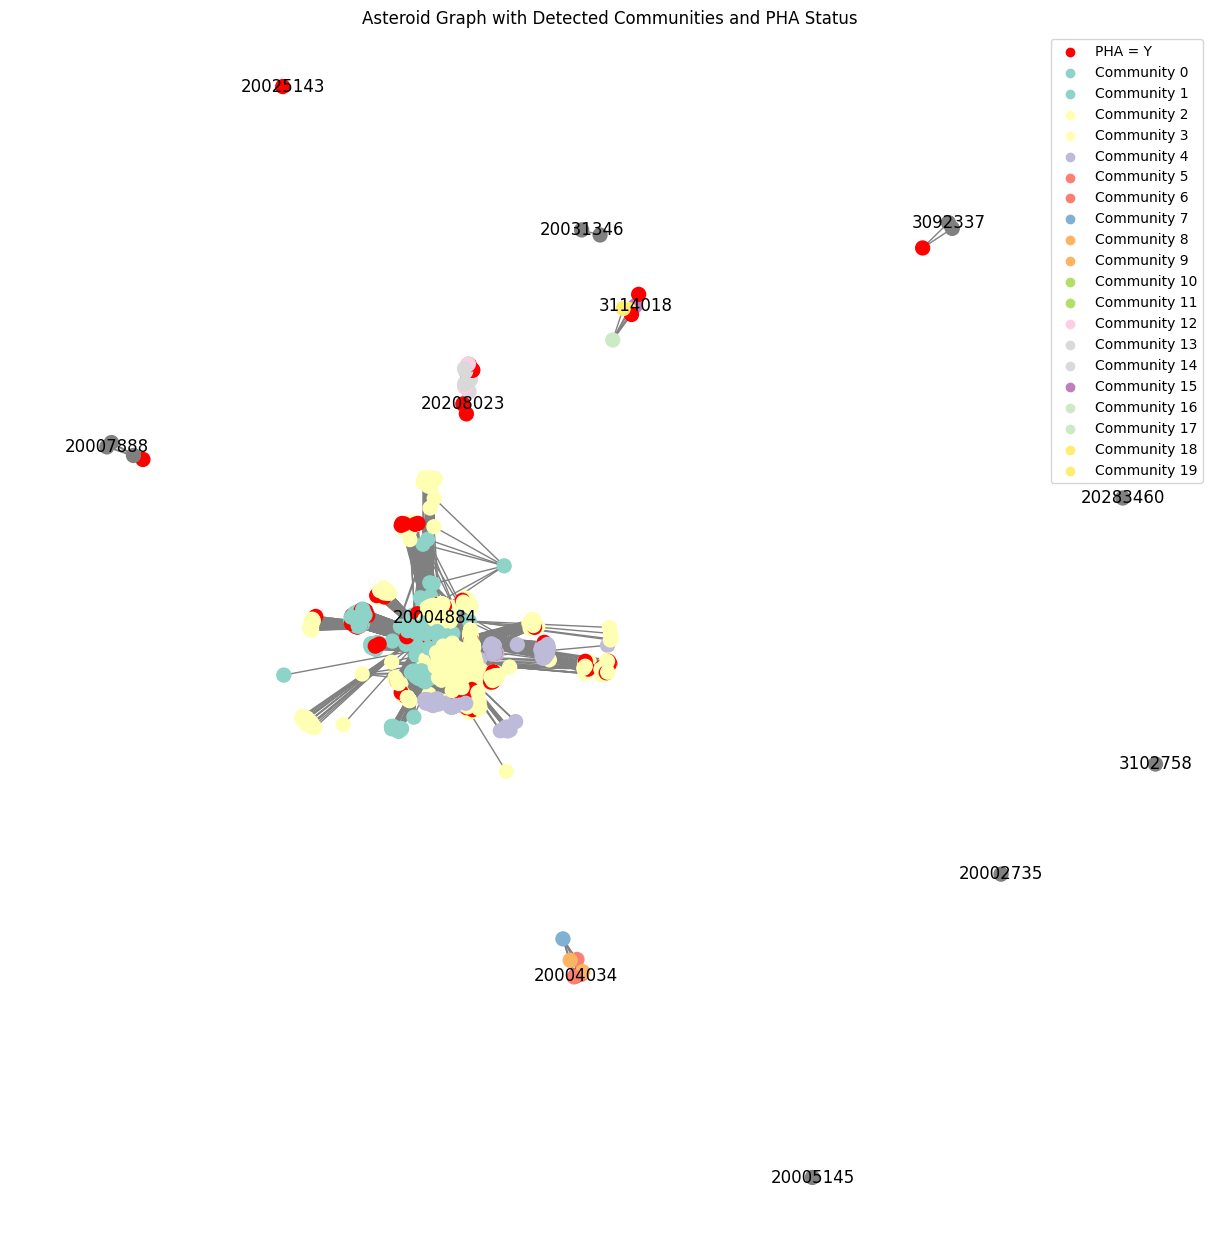

Execution time: 127.62 seconds


In [37]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import time
from networkx.algorithms.community import asyn_fluidc

start_time = time.time()

# Initialize the graph
I = nx.Graph()

# Step 1: Add nodes (each asteroid is a node, identified by its 'spkid')
for index, row in asteroid_color.iterrows():
    I.add_node(row['spkid'], 
               BV=row['BV'], 
               UB=row['UB'], 
               spec_B=row['spec_B'], 
               spec_T=row['spec_T'], 
               pha=row['pha'])  # Store PHA status

# Prepare to calculate similarities
sim_data = []  # To store the similarity pairs
sim_scores = {}  # To store average similarity for each node

# Step 2: Calculate similarity scores and add edges
for i, row1 in asteroid_color.iterrows():
    total_sim = 0
    count = 0
    for j, row2 in asteroid_color.iterrows():
        if i < j:  # Avoid self-comparisons and duplicates
            score = similarity_score(row1, row2)  # Define your similarity_score function
            if score > 0:  # Only consider non-zero similarity scores
                # Add to similarity data
                sim_data.append({
                    'spkid_1': row1['spkid'],
                    'spkid_2': row2['spkid'],
                    'similarity_score': score
                })
                
                # Add edge to the graph
                I.add_edge(row1['spkid'], row2['spkid'], weight=score)

                # Accumulate scores for average calculation
                total_sim += score
                count += 1
    
    # Calculate average similarity for each node
    sim_scores[row1['spkid']] = total_sim / count if count > 0 else 0

# Convert similarity_data to a DataFrame (if needed)
sim_df = pd.DataFrame(sim_data)

# Step 3: Detect connected components and apply asyn_fluidc to each
connected_components = list(nx.connected_components(I))
k = 5  # Define the number of communities you expect to find

# For each connected component, apply community detection
community_index = 0  # Global community index across components
for component in connected_components:
    subgraph = I.subgraph(component)  # Get the subgraph for each component
    if len(subgraph) >= k:  # Only apply fluidc if there are enough nodes
        # Run community detection on this subgraph
        sub_communities = list(asyn_fluidc(subgraph, k=min(k, len(subgraph)), max_iter=100))
        
        # Assign communities in the global graph
        for community in sub_communities:
            for node in community:
                I.nodes[node]['community'] = community_index
            community_index += 1

# Step 4: Node Coloring based on PHA status and detected communities
node_colors = []

# Define a colormap for detected communities
community_cmap = plt.cm.get_cmap('Set3', community_index)  # Use a qualitative colormap with distinct colors

for node in I.nodes(data=True):
    pha_value = node[1]['pha']  # PHA status from the graph
    community_value = node[1].get('community', -1)  # Detected community from the graph
    
    if pha_value == 'Y':  # Color for PHA = 'Y'
        node_colors.append('red')  # Color red for PHAs
    else:  # Non-PHA
        if community_value != -1:
            # Assign a color from the community colormap based on the detected community
            node_colors.append(community_cmap(community_value / (community_index - 1)))
        else:
            # If no community, assign a default gray color
            node_colors.append('gray')

# Step 5: Select one node from each component to label (e.g., the first node)
labels = {}  # Dictionary to store labels
components = list(nx.connected_components(I))

for component in components:
    # Select one node from the component (you can use any strategy; here we use the first node)
    selected_node = next(iter(component))  # Get the first node from the component
    labels[selected_node] = selected_node  # Label this node with its 'spkid'

# Step 6: Visualize the Graph with Node Colors and Selective Labels
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(I, iterations=15, seed=42)

# Draw the graph
nx.draw(I, 
        with_labels=False, 
        node_color=node_colors, 
        node_size=100, 
        edge_color='gray', 
        font_size=10,
        pos=pos)

# Optionally, add a legend for PHA nodes and communities
plt.scatter([], [], color='red', label='PHA = Y')
for i in range(community_index):
    # Example for a representative color for each community
    plt.scatter([], [], color=community_cmap(i / (community_index - 1)), label=f'Community {i}')

# Add selective labels (only for the chosen nodes)
nx.draw_networkx_labels(I, pos, labels=labels, font_size=12, font_color='black')

plt.legend()
plt.title('Asteroid Graph with Detected Communities and PHA Status')
plt.show()

end_time = time.time()
execution_time = end_time - start_time

print(f"Execution time: {execution_time:.2f} seconds")

C:\Users\stack\AppData\Local\Temp\ipykernel_15024\3995880498.py:87: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  community_cmap = plt.cm.get_cmap('Set3', k)


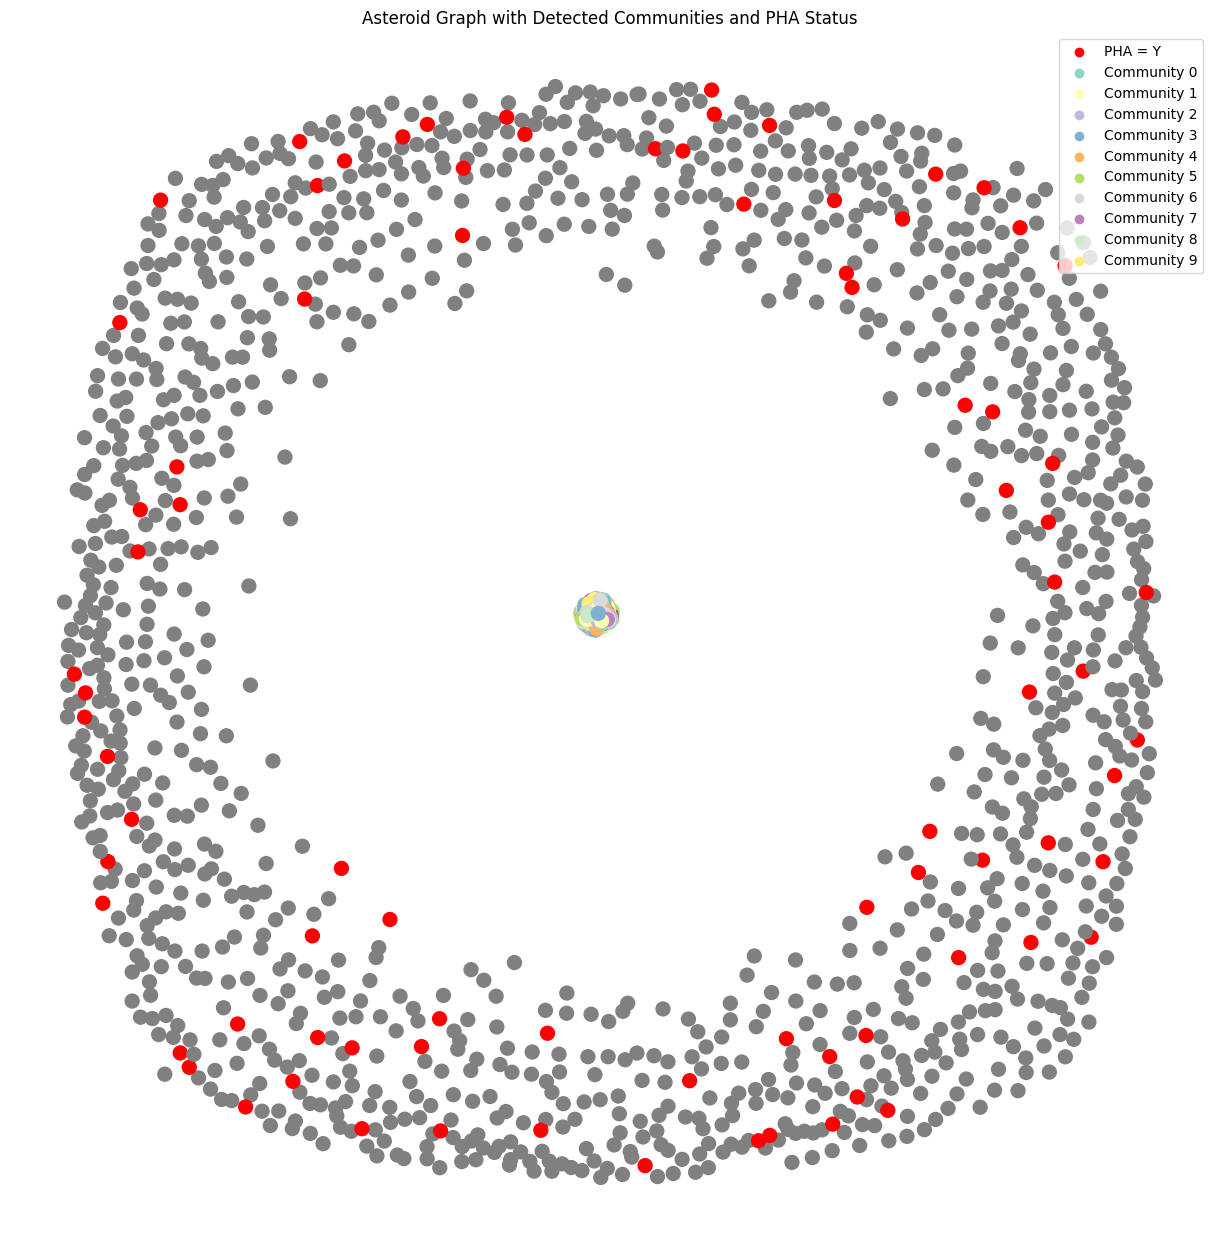

Execution time: 106.38 seconds


In [41]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import time
from networkx.algorithms.community import asyn_fluidc

def similarity_score(row1, row2):
    return abs(row1['BV'] - row2['BV']) + abs(row1['UB'] - row2['UB'])

start_time = time.time()

# Initialize the graph
I = nx.Graph()

# Step 1: Add nodes
for index, row in asteroid_color.iterrows():
    I.add_node(row['spkid'], 
               BV=row['BV'], 
               UB=row['UB'], 
               spec_B=row['spec_B'], 
               spec_T=row['spec_T'], 
               pha=row['pha'])

# Prepare to calculate similarities
sim_data = []
sim_scores = {}

# Step 2: Calculate similarity scores and add edges
for i, row1 in asteroid_color.iterrows():
    total_sim = 0
    count = 0
    for j, row2 in asteroid_color.iterrows():
        if i < j:
            score = similarity_score(row1, row2)
            if score > 0:
                sim_data.append({
                    'spkid_1': row1['spkid'],
                    'spkid_2': row2['spkid'],
                    'similarity_score': score
                })
                I.add_edge(row1['spkid'], row2['spkid'], weight=score)
                total_sim += score
                count += 1
    sim_scores[row1['spkid']] = total_sim / count if count > 0 else 0

# Step 3: Detect connected components and apply asyn_fluidc to each
connected_components = list(nx.connected_components(I))
k = 10  # Desired number of communities

# Store communities
community_index = 0
community_labels = {}

# For each connected component
for component in connected_components:
    subgraph = I.subgraph(component)
    num_nodes = len(subgraph.nodes())
    
    if num_nodes > 1:
        # Set k to the minimum of desired k or number of nodes in the subgraph
        sub_k = min(k, num_nodes)
        
        # Check if sub_k is greater than 1 before proceeding
        if sub_k > 1:
            sub_communities = list(asyn_fluidc(subgraph, k=sub_k))
            
            for community in sub_communities:
                for node in community:
                    community_labels[node] = community_index
                community_index += 1

# Limit the number of communities to k
if community_index > k:
    # Create a mapping to reduce communities
    community_count = {i: 0 for i in range(k)}
    for node in community_labels:
        assigned_community = community_labels[node]
        if assigned_community < k:
            community_count[assigned_community] += 1
        else:
            # Assign to the largest community if over the limit
            largest_community = max(community_count, key=community_count.get)
            community_labels[node] = largest_community

# Step 4: Color nodes based on community labels
node_colors = []
community_cmap = plt.cm.get_cmap('Set3', k)

for node in I.nodes(data=True):
    pha_value = node[1]['pha']
    community_value = community_labels.get(node[0], -1)
    
    if pha_value == 'Y':
        node_colors.append('red')
    else:
        if community_value != -1:
            node_colors.append(community_cmap(community_value / (k - 1)))
        else:
            node_colors.append('gray')

# Visualization
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(I, iterations=15, seed=42)
nx.draw(I, 
        with_labels=False, 
        node_color=node_colors, 
        node_size=100, 
        edge_color='gray', 
        font_size=10,
        pos=pos)

plt.scatter([], [], color='red', label='PHA = Y')
for i in range(k):
    plt.scatter([], [], color=community_cmap(i / (k - 1)), label=f'Community {i}')
plt.legend()
plt.title('Asteroid Graph with Detected Communities and PHA Status')
plt.show()

end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time:.2f} seconds")


### Comments

It is obvious that the majority of the asteroids with a spectral attribute are in the main asteroid belt, due to proximity

### With Concurrent

In [30]:
import concurrent.futures

# Function to calculate the similarity score for a pair of asteroids
def calculate_similarity(row1, row2):
    score = similarity_score(row1, row2)  # Replace with your similarity function
    if score > 0:
        return {
            'spkid_1': row1['spkid'],
            'spkid_2': row2['spkid'],
            'similarity_score': score
        }
    return None  # If similarity is 0 or negative, return None

def compute_similarities_for_row(i, row1):
    total_sim = 0
    count = 0
    local_edges = []
    for j, row2 in asteroid_color.iterrows():
        if i < j:  # Avoid self-comparisons and duplicates
            result = calculate_similarity(row1, row2)
            if result:
                local_edges.append(result)  # Collect valid similarity scores
                total_sim += result['similarity_score']
                count += 1
    average_sim = total_sim / count if count > 0 else 0
    return local_edges, row1['spkid'], average_sim

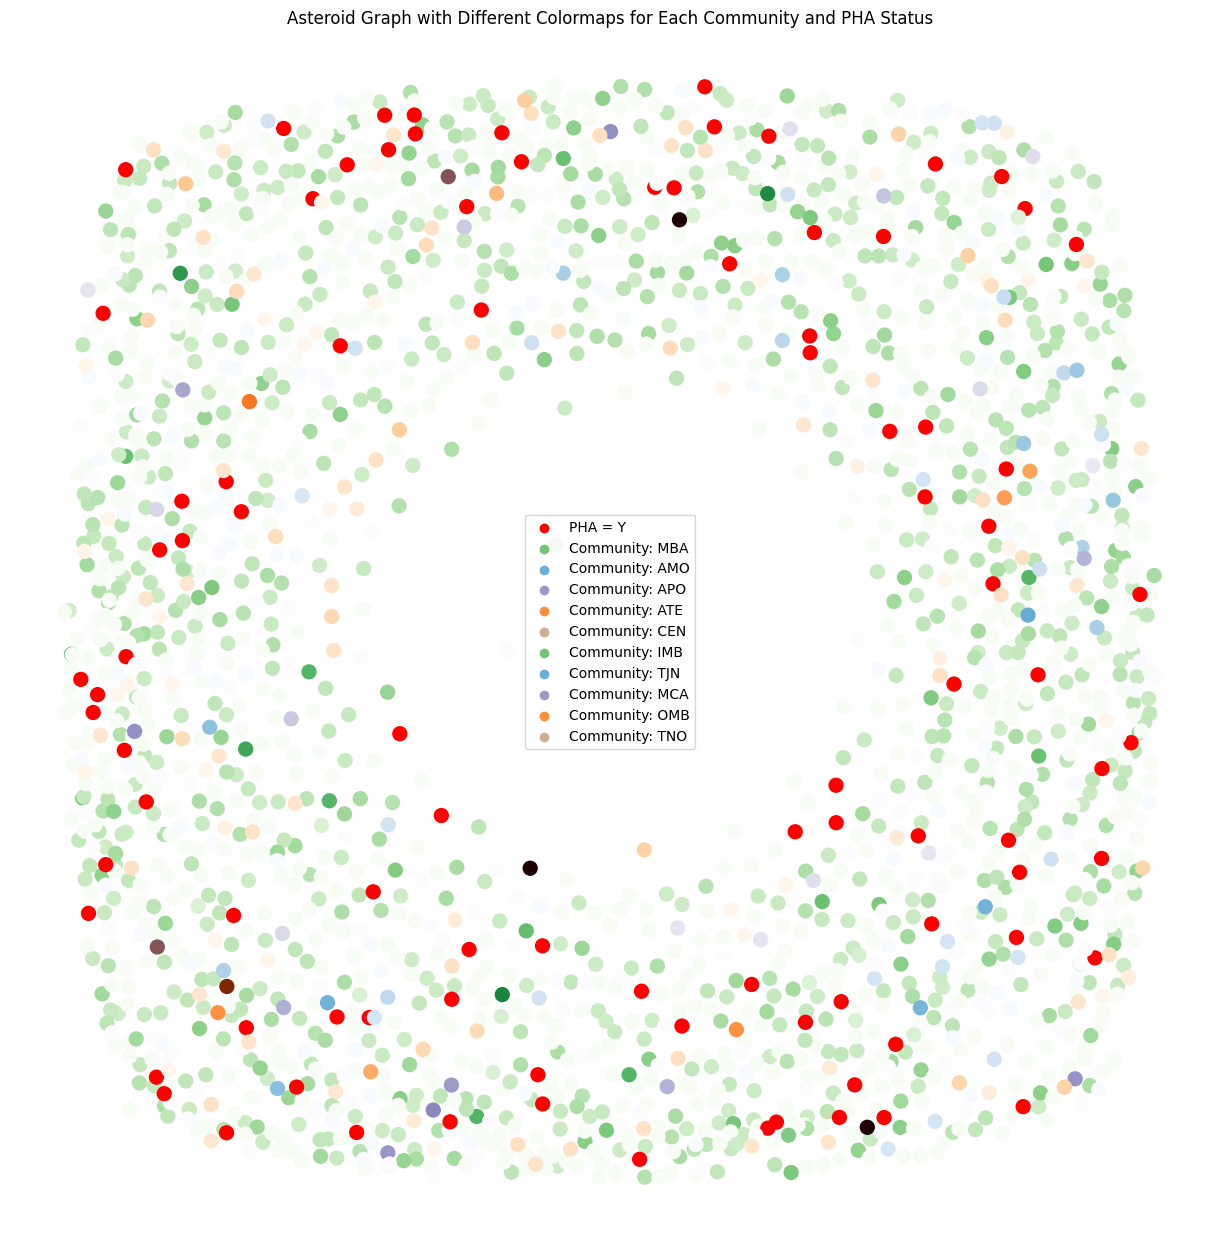

Execution time: 100.05 seconds


In [44]:
start_time = time.time()

I = nx.Graph()

# Step 1: Add nodes (each asteroid is a node, identified by its 'spkid')
for index, row in asteroid_color.iterrows():
    I.add_node(row['spkid'], 
               BV=row['BV'], 
               UB=row['UB'], 
               spec_B=row['spec_B'], 
               spec_T=row['spec_T'], 
               community=row['class'])  # Store community (class)

# Prepare to calculate similarities
sim_data = []  # To store the similarity pairs
sim_scores = {}  # To store average similarity for each node

# Using ThreadPoolExecutor to parallelize the similarity calculations
with concurrent.futures.ThreadPoolExecutor() as executor:
    futures = [executor.submit(compute_similarities_for_row, i, row1) for i, row1 in asteroid_color.iterrows()]
    
    for future in concurrent.futures.as_completed(futures):
        local_edges, spkid, avg_sim = future.result()
        sim_data.extend(local_edges)  # Add edges to sim_data
        sim_scores[spkid] = avg_sim   # Store average similarity score for this node

# Convert similarity_data to a DataFrame
sim_df = pd.DataFrame(sim_data)

# Step 3: Visualize the Graph with Different Colormaps for Each Community and PHA Colors
node_colors = []

# Define distinct colormaps for each community
community_cmaps = {
    'MBA': plt.cm.Greens,
    'AMO': plt.cm.Blues, 
    'APO': plt.cm.Purples,    
    'ATE': plt.cm.Oranges, 
    'CEN': plt.cm.pink,  
    'IMB': plt.cm.Greens,  
    'TJN': plt.cm.Blues,  
    'MCA': plt.cm.Purples, 
    'OMB': plt.cm.Oranges,  
    'TNO': plt.cm.pink
}

# Assign colors based on PHA status and community-specific colormaps
for node in I.nodes(data=True):
    # Use the original DataFrame to get PHA status and community
    pha_value = asteroid_color.loc[asteroid_color['spkid'] == node[0], 'pha'].values[0]
    community_value = node[1]['community']  # Community from the graph
    
    if pha_value == 'Y':  # PHA
        node_colors.append('red')  # Color for PHA = 'Y'
    else:  # Non-PHA
        # Get the community-specific colormap and normalize the similarity score for coloring
        norm = plt.Normalize(vmin=0, vmax=max(sim_scores.values()))
        cmap = community_cmaps.get(community_value)  # Default to gray if class not found
        sim_score = sim_scores[node[0]]
        node_colors.append(cmap(norm(sim_score)))  # Color from the gradient

# Step x: Select one node from each component to label (e.g., the first node)
labels = {}  # Dictionary to store labels
components = list(nx.connected_components(I))

for component in components:
    # Select one node from the component (you can use any strategy; here we use the first node)
    selected_node = next(iter(component))  # Get the first node from the component
    labels[selected_node] = selected_node  # Label this node with its 'spkid'

# Draw the graph with node colors based on PHA and community-specific colors
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(I, iterations=5, seed=42)

nx.draw(I,  # Use the renamed graph I
        with_labels=False, 
        node_color=node_colors, 
        node_size=100, 
        edge_color='gray', 
        font_size=10,
        pos = pos)

# Optionally, add a legend for PHA nodes and communities
plt.scatter([], [], color='red', label='PHA = Y')

for cls, cmap in community_cmaps.items():
    # Example for a representative color
    plt.scatter([], [], color=cmap(0.5), label=f'Community: {cls}')  # Mid-point color example
# Step 4: Add selective labels (only for the chosen nodes)
#nx.draw_networkx_labels(I, pos, labels=labels, font_size=12, font_color='black')    
plt.legend()
plt.title('Asteroid Graph with Different Colormaps for Each Community and PHA Status')
plt.show()

end_time = time.time()
execution_time = end_time - start_time

print(f"Execution time: {execution_time:.2f} seconds")